<a href="https://colab.research.google.com/github/Edgal4/Edgal4/blob/main/Img2Img_ControlNet_(Non_Finetuned).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install dependencies (~1 min)

# %%capture
!pip install diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-62u3yc5_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-62u3yc5_
  Resolved https://github.com/huggingface/accelerate.git to commit 873b39b85bc5b4eb87da9ba6af1adc0e418be907
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
  Created wheel for accelerate: filename

In [ ]:
#@title Import libraries
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector
from diffusers.utils import load_image
from IPython.display import Image
from PIL import Image
import numpy as np
import torch
from google.colab import files
from os import path
import os.path

Saving lvngrm (19).jpg to lvngrm (19).jpg


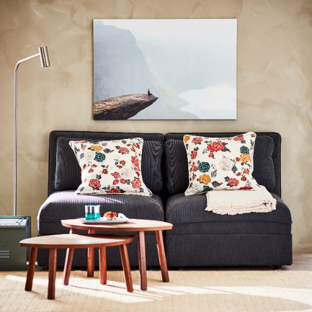

In [ ]:
#@title Upload a single room image here
if path.exists('/content/images') == False:
  os.mkdir('/content/images')

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
Image.open(image_path).resize((312,312))

In [ ]:
#@title Define the ControlNet class
class ControlNetMLSD:

    def __init__(self, 
                #  prompt, 
                 image_path,
                 output_dir,
                 mlsd_net='lllyasviel/ControlNet',
                 ):
        
        self.image_path = image_path
        self.output_dir = output_dir
        self.mlsd_net = mlsd_net
        self.mlsd = MLSDdetector.from_pretrained(self.mlsd_net)

        # Check the CPU
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # If GPU not available in torch then throw error up instantiation
        if self.device == 'cpu':
            raise MemoryError('GPU needed for inference in this project')
        
        assert isinstance(image_path, str), 'Image path must be a string linking to an image'

    def generate_mlsd_image(self,
                            num_inf_steps=50, 
                            ):
      
        self.num_inf_steps = num_inf_steps
        self.mlsd_image_path = f"{self.output_dir}/mlsd_seg.jpeg"

        image_loaded = load_image(self.image_path)
        mlsd_image = self.mlsd(image_loaded)

        if self.mlsd_image_path is not None:
            # Checks if there is a path to save the image
            mlsd_image.save(self.mlsd_image_path)
            print(f'[IMAGE SAVE INFO] MLSD image saved to path specified:{self.mlsd_image_path}')
        else:
          print("Invalid filepath. Cannot save MLSD image.")

[IMAGE SAVE INFO] MLSD image saved to path specified:/content/images/mlsd_seg.jpeg


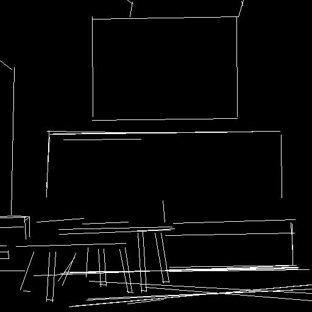

In [ ]:
#@title Generate MLSD file
output_dir = '/content/images'
c_net = ControlNetMLSD(image_path=image_path,
                       output_dir=output_dir)

c_net.generate_mlsd_image()
mlsd_image = Image.open("/content/images/mlsd_seg.jpeg")

Image.open('/content/images/mlsd_seg.jpeg').resize((312,312))

In [ ]:
#@title Load model (~1.5min)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-mlsd", 
                                             torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controlnet, 
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Define 4 prompts here (4 images will be generated)

In [ ]:
prompt1 = "white sofa"
prompt2 = "mid-century interior design, dark colors"
prompt3 = "Scandinavian room style"
prompt4 = "minimalistic, open, neutral autumn colors"

  0%|          | 0/20 [00:00<?, ?it/s]

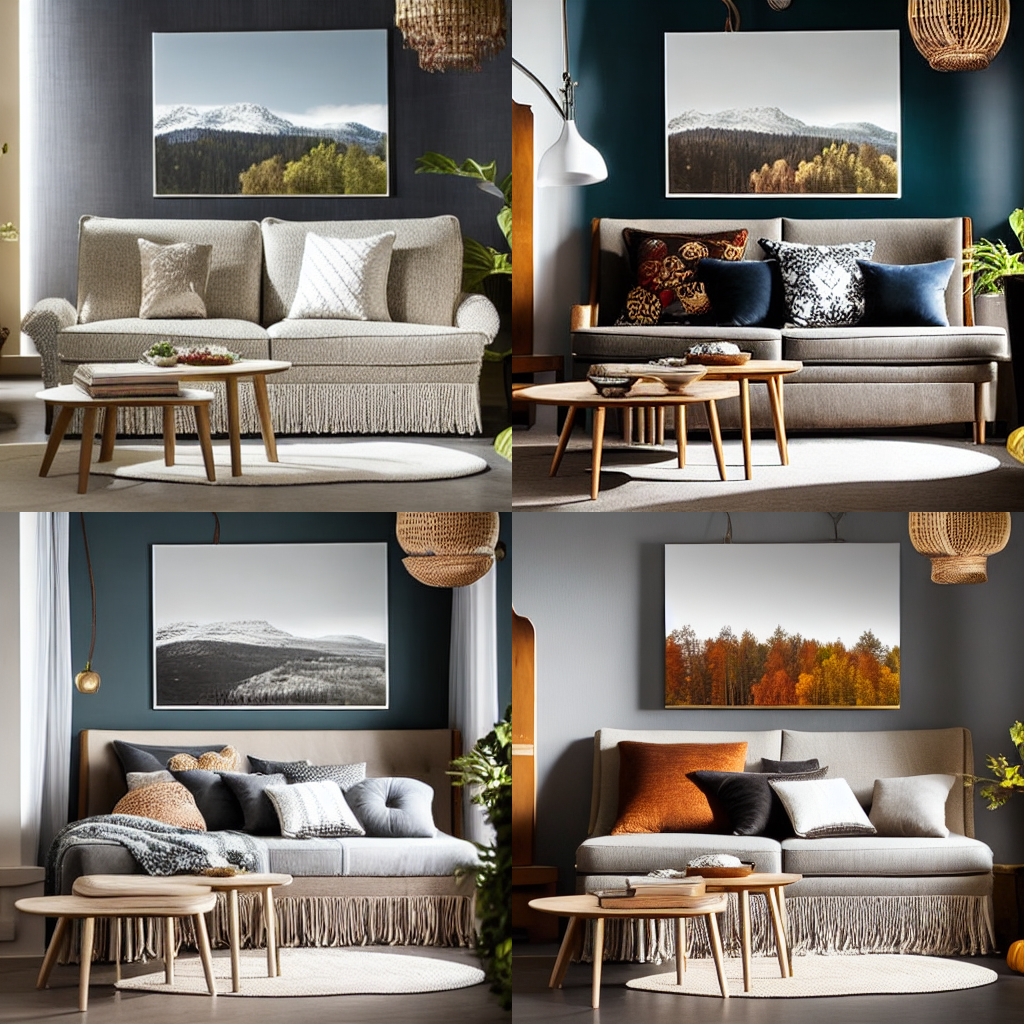

In [ ]:
#@title Generate images
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in [prompt1, 
                               prompt2, 
                               prompt3, 
                               prompt4
                               ]]

generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    mlsd_image,
    negative_prompt=["((deformed))), ((ugly)), blurry, ((bad anatomy)), ((bad proportions)), lowres, cartoon, fake"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)